In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import pandas as pd
import csv
import glob
import numpy as np
import matplotlib.pyplot as plt
import converter
import glob
import os
import re

In [3]:
def load_data(path):
    def func(x):
        """Extracts input size from file name"""
        v = x.split(".")[-2].split("-")[-1]
        return int(v)
    
    data = {}

    for filename in glob.iglob(path):
        # extract name
        name = filename.replace("../", "").split(".")[0]

        # read file
        df = pd.read_csv(filename, index_col="Filename")

        # make column names lower-case and remove spaces
        df = df.rename(columns=lambda x: x.strip().lower())    

        # add encoding and message (tyencodepe) columns
        df['format'] = np.where(df.index.str.endswith(".ber"), 'BER', 'XER')
        df['message'] = np.where(df.index.str.contains("data-request"), 'data-request', 'data-response')

        # drop total
        df = df.drop(axis=1, columns=['total'])

        # rename average to the name of this data set
        df = df.rename(columns={"average": name})

        # create input-size parameter
        df['input-size'] = df.index.map(func)

        # save df
        data[name] = df
    
    return data

data = load_data("../*.csv")

In [4]:
def draw(data, xlabel, ylabel, logy=False):
    plt.figure()
    plt.rc('font', family='Liberation Mono')# Latin Modern Mono
    plt.rc('xtick', labelsize='small')
    plt.rc('ytick', labelsize='small')
    ax = data.sort_index().plot(grid=True, logy=logy)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Encoding

In [5]:
encode_xml = data["encode-c"][data["encode-c"]["format"] == 'XER'].sort_values(
    by='input-size'
).drop(['bytes', 'format'], axis=1
      ).rename(columns={'encode-c': 'encode-c-xml'})

encoding = pd.merge(data["encode-python"], data["encode-c"], how='inner').drop(['bytes', 'format'], axis=1)
encoding = pd.merge(encoding, encode_xml, on=['message', 'input-size'], how='inner')
encoding = pd.merge(encoding, data["encode-java"], on=['message', 'input-size'], how='inner').drop(['format', 'bytes'], axis=1)
encoding = encoding.rename(columns={
    'encode-java': 'jASN1',
    'encode-c': 'asn1c',
    'encode-python': 'PyASN1'
})

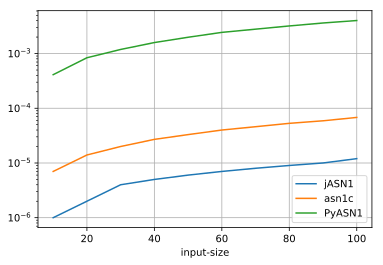

In [6]:
req_enc_time = encoding[encoding['message'] == 'data-request'].sort_values(
    by='input-size'
)
req_enc_time.plot(
    x='input-size',
    y=['jASN1', 'asn1c', 'PyASN1',
       #'decode-c-xml', 
    ],
    grid=True,
    logy=True
)

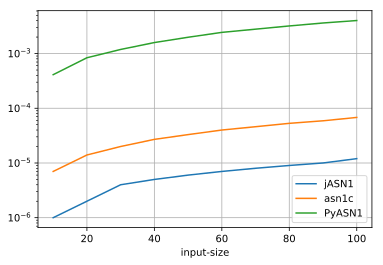

In [7]:
res_enc_time = encoding[encoding['message'] == 'data-response'].sort_values(by='input-size')
req_enc_time.plot(
    x='input-size',
    y=['jASN1', 'asn1c', 'PyASN1',
       #'decode-c-xml', 
      ],
    grid=True,
    logy=True
)

# Decoding

In [8]:
decode_xml = data["decode-c"][data["decode-c"]["format"] == 'XER'].sort_values(
    by='input-size'
).drop(['bytes', 'format'], axis=1
      ).rename(columns={'decode-c': 'decode-c-xml'})

decoding = pd.merge(data["decode-python"], data["decode-c"], how='inner').drop(['bytes', 'format'], axis=1)
decoding = pd.merge(decoding, decode_xml, on=['message', 'input-size'], how='inner')
decoding = pd.merge(decoding, data["decode-java"], on=['message', 'input-size'], how='inner').drop(['format', 'bytes'], axis=1)
decoding = decoding.rename(columns={
    'decode-java': 'jASN1',
    'decode-c': 'asn1c',
    'decode-python': 'PyASN1'
})

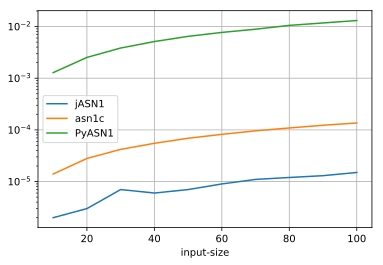

In [9]:
req_dec_time = decoding[decoding['message'] == 'data-request'].sort_values(
    by='input-size'
)
req_dec_time.plot(
    x='input-size',
    y=['jASN1', 'asn1c', 'PyASN1',
       #'decode-c-xml', 
      ],
    grid=True,
    logy=True
)

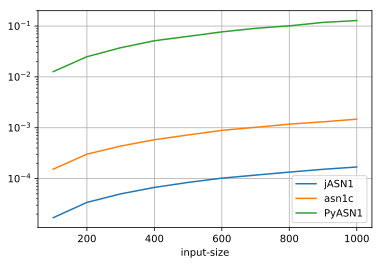

In [10]:
res_dec_time = decoding[decoding['message'] == 'data-response'].sort_values(by='input-size')
res_dec_time.plot(
    x='input-size',
    y=['jASN1', 'asn1c', 'PyASN1',
       #'decode-c-xml', 
      ],
    grid=True,
    logy=True
)

## Message sizes

In [11]:
files = glob.iglob("../message-*")
sizes = []

for f in files:
    sizes.append({
        'size': int(os.stat(f).st_size),
        'format': f.split(".")[-1].upper(),
        'input-size': int(re.findall(r'\d+', f)[0]),
        'message': 'data-response' if 'data-response' in f else 'data-request'
    })

In [12]:
data_requests = pd.DataFrame(columns=[f.upper() for f in converter.OUTPUT_FORMATS])
for s in sizes:
    if s['message'] == 'data-request':
        index  =  s['input-size']
        format_ = s['format'] 
        value = s['size']
        data_requests.at[index, format_] = int(value)

In [13]:
data_responses = pd.DataFrame(columns=[f.upper() for f in converter.OUTPUT_FORMATS])
for s in sizes:
    if s['message'] == 'data-response':
        index  =  s['input-size']
        format_ = s['format'] 
        value = s['size']
        data_responses.at[index, format_] = int(value)

<Figure size 432x288 with 0 Axes>

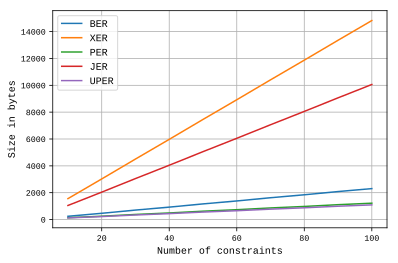

In [14]:
draw(data_requests, "Number of constraints", "Size in bytes")
# data_requests.divide(data_responses["BER"], axis="index").sort_index()

<Figure size 432x288 with 0 Axes>

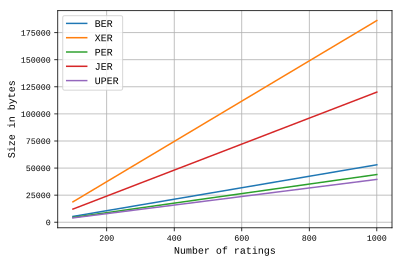

In [15]:
draw(data_responses, "Number of ratings", "Size in bytes")
# data_responses.divide(data_responses["BER"], axis="index").sort_index()